In [46]:
from efficient_kan import KAN
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.interpolate import BSpline
from torch.utils.data import DataLoader
from kan.utils import create_dataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

In [272]:
def visualize_kan(model, idx):
    l = idx[0]
    i = idx[1]
    j = idx[2]

    grid_size= model.grid_size
    spline_order = model.spline_order
    weights = model.layers[l].spline_weight[i][j].detach().numpy()
    scale_base = model.layers[l].base_weight[i][j]
    knot_vector = np.concatenate(([-1] * spline_order, np.linspace(-1, 1, grid_size), [1] * spline_order))

    t = np.linspace(-1, 1, 100)

    spline = BSpline(knot_vector, weights, spline_order)
    spline_values = spline(t)
    
    silu = nn.SiLU()
    bias = silu(torch.tensor(t))

    acts = spline_values + bias.numpy()*scale_base.detach().numpy()

    plt.figure(figsize=(4, 3))
    plt.plot(t, spline_values, label='B-spline curve')
    plt.plot(t, bias.numpy()*scale_base.detach().numpy(), label='Bias')
    plt.plot(t, acts, label='Activation')
    # plt.scatter(np.linspace(-1, 1, len(weights)), weights, color='red', label='Control points')
    plt.title('B-spline Curve')
    plt.xlabel('t')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


import numpy as np
from scipy.interpolate import BSpline
from scipy.stats import spearmanr
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def spearman_corrs(model, idx):
    l, i, j = idx
    t = np.linspace(-1, 1, 100)
    weights = model.layers[l].spline_weight[i][j].detach().numpy()
    scale_base = model.layers[l].base_weight[i][j].item()
    
    knot_vector = np.concatenate(([-1] * model.spline_order, 
                                  np.linspace(-1, 1, model.grid_size), 
                                  [1] * model.spline_order))
    
    spline_values = BSpline(knot_vector, weights, model.spline_order)(t)
    bias = nn.SiLU()(torch.tensor(t)).numpy() * scale_base
    acts = spline_values + bias
    
    corr = lambda x, y: spearmanr(x, y)[0]
    deriv = lambda y: np.gradient(y, t)
    
    return (corr(acts, bias), 
            corr(deriv(acts), deriv(bias)))

def visualize_kan(model, idx):
    t = np.linspace(-1, 1, 100)
    l, i, j = idx
    weights = model.layers[l].spline_weight[i][j].detach().numpy()
    scale_base = model.layers[l].base_weight[i][j].item()
    
    knot_vector = np.concatenate(([-1] * model.spline_order, 
                                  np.linspace(-1, 1, model.grid_size), 
                                  [1] * model.spline_order))
    
    spline_values = BSpline(knot_vector, weights, model.spline_order)(t)
    bias = nn.SiLU()(torch.tensor(t)).numpy() * scale_base
    acts = spline_values + bias
    
    corr, corr_deriv = spearman_corrs(model, idx)
    print(f"Spearman correlation: acts vs bias: {corr:.6f}, derivatives: {corr_deriv:.6f}")
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    axs[0].plot(t, spline_values, label='B-spline curve')
    control_points_t = np.linspace(-1, 1, len(weights))
    axs[0].scatter(control_points_t, weights, color='red', label='Control points')
    axs[0].set(title=f"B-spline", xlabel='t', ylabel='Value')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot Bias and Activation
    for ax, (data, title) in zip(axs[1:], [(bias, 'SiLU'), (acts, 'Activation function')]):
        ax.plot(t, data)
        ax.set(title=f"{title}", xlabel='t', ylabel='Value')
        ax.grid(True)
    
    fig.suptitle(f"KAN activation function components at layer {l}, edge between nodes {j}, {i}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return corr, corr_deriv

model = KAN([55,8,2], grid_size=5)



Spearman correlation: acts vs bias: 1.000000, derivatives: 1.000000


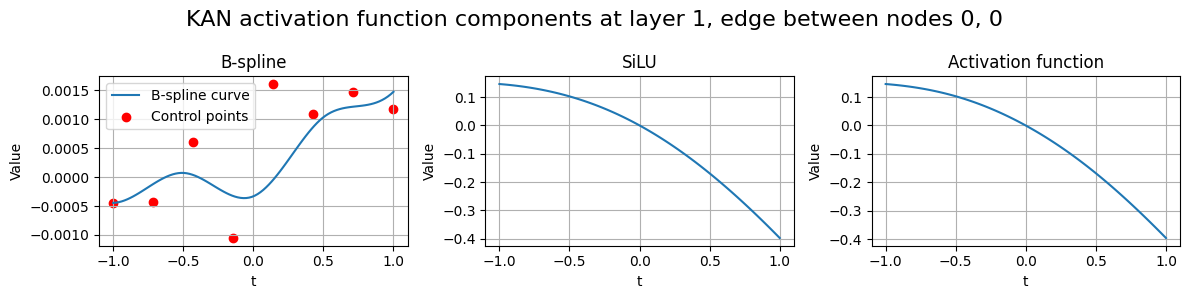

(0.9999999999999999, 0.9999999999999999)

In [273]:
# cp = torch.load("models/saved/KAN/lunar-sweep-101.pth", map_location=DEVICE) # adam best
cp = torch.load("models/saved/KAN/daily-sweep-67.pth", map_location=DEVICE) # lbfgs best



model.load_state_dict(cp)

visualize_kan(model, [1, 0, 0])

# visualize_kan(model.layers[0].spline_weight[1][1].detach().numpy(), torch.abs(model.layers[1].base_weight[0][0])/10)


# print(model.layers[1].base_weight[0][0])

# print(model.layers[1].spline_weight[0][0])




[[0.9999999999999999, 0.9965916591659165, 0.9999999999999999, 0.9999879987998799, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999], [0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999], [0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999], [0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999], [0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999], [0.9999999999999999, 0.9635643564356435, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999], [0.9999999999999999, 0.9999

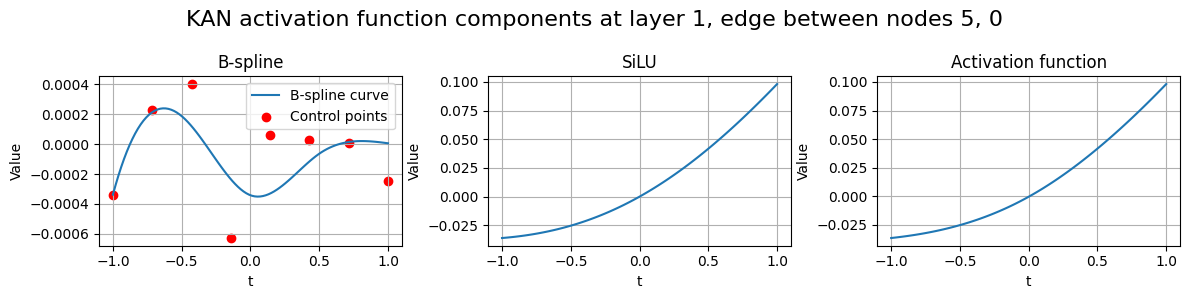

1 1 5
Spearman correlation: acts vs bias: 1.000000, derivatives: 1.000000


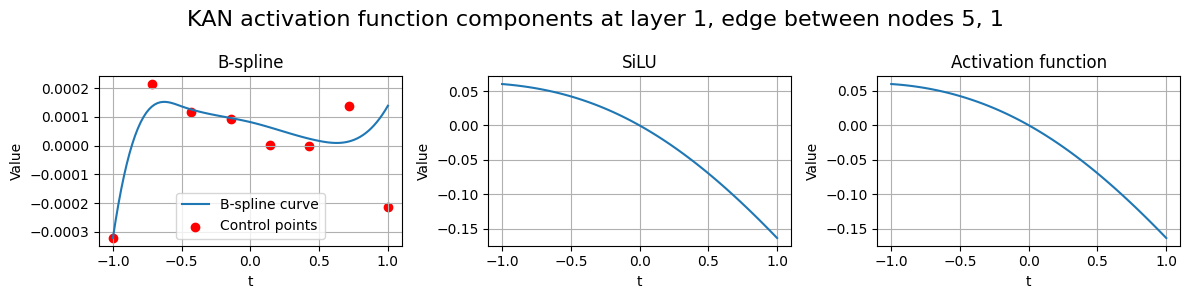

1 0 6
Spearman correlation: acts vs bias: 1.000000, derivatives: 1.000000


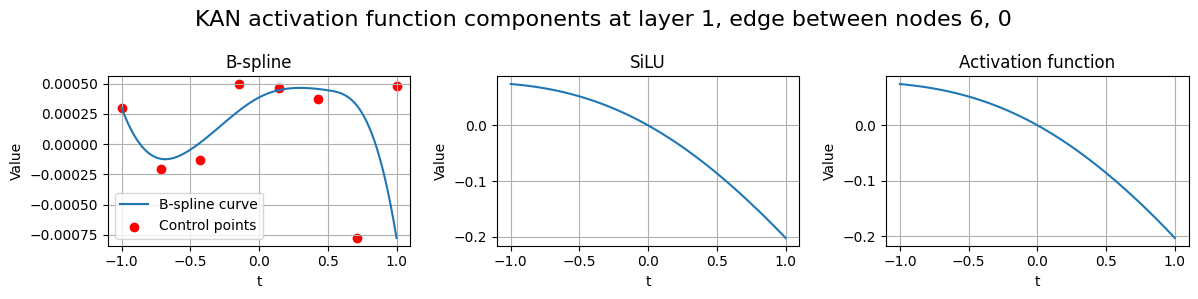

1 1 6
Spearman correlation: acts vs bias: 1.000000, derivatives: 1.000000


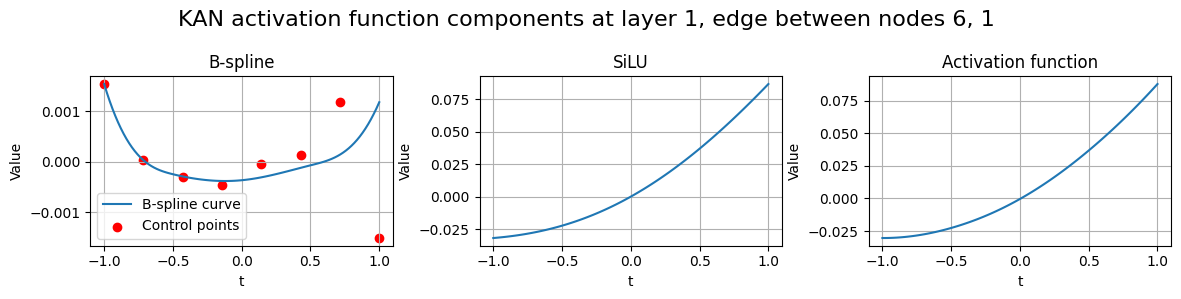

1 0 7
Spearman correlation: acts vs bias: 1.000000, derivatives: 1.000000


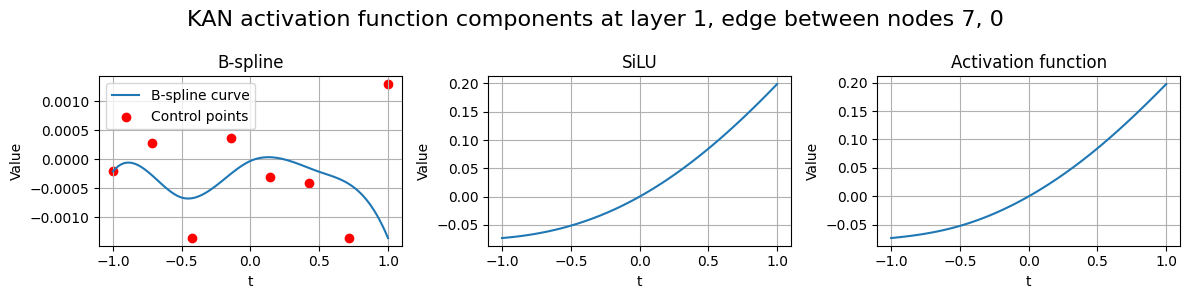

mean corrs: 0.9982399818929261
mean grad corrs: 0.9901267231986356


In [274]:


base_diff = []

corrs = []
grad_corrs = []

for l,layer in enumerate(model.layers):
    corrs.append([])
    grad_corrs.append([])
    for j in range(layer.base_weight.shape[1]):
        node_corrs = []
        node_grad_corrs = []
        for i in range(layer.base_weight.shape[0]):
            
            diff = layer.spline_weight[i][j].max() - layer.spline_weight[i][j].min()
            base = layer.base_weight[i][j]
            corr, grad_corr = spearman_corrs(model, [l,i,j])
            
            edge = {
                "corr": corr,
                "grad_corr": grad_corr,
                "diff": diff,
                "base": abs(base),
                "idx": [l,i,j],
            }
            base_diff.append(edge)
            node_corrs.append(corr)
            node_grad_corrs.append(grad_corr)

        corrs[l].append(node_corrs)
        grad_corrs[l].append(node_grad_corrs)

        # corrs[l].append(np.mean(node_corrs))
        # grad_corrs[l].append(np.mean(node_grad_corrs))

# print(grad_corrs)

print(grad_corrs[0])

diff = sorted(base_diff, key=lambda x: x["diff"], reverse=True)
base = sorted(base_diff, key=lambda x: x["base"], reverse=False)
flat_corrs = sorted(base_diff, key=lambda x: x["corr"], reverse=False)
flat_grad_corrs = sorted(base_diff, key=lambda x: x["grad_corr"], reverse=False)


print(base[0])
print(base[1])
print(base[2])
print(base[3])

print(len(base))

# top 5 idx from base
for t in range(450,455,1):
    l = flat_corrs[t]['idx'][0]
    i = flat_corrs[t]['idx'][1]
    j = flat_corrs[t]['idx'][2]
    print(l,i,j)
    # visualize_kan(model.layers[l].spline_weight[i][j].detach().numpy(), model.layers[l].base_weight[i][j])
    visualize_kan(model, [l,i,j])
                          
print(f"mean corrs: {np.mean([x['corr'] for x in flat_corrs])}")
print(f"mean grad corrs: {np.mean([x['grad_corr'] for x in flat_corrs])}")
# t = 2
# l = base[t]['idx'][0]
# i = base[t]['idx'][1]
# j = base[t]['idx'][2]
# print(l,i,j)
# visualize_kan(model.layers[l].spline_weight[i][j].detach().numpy(), model.layers[l].base_weight[i][j])

            
        

# visualize_kan(model.layers[0].spline_weight[22][23].detach().numpy(), model.layers[0].base_weight[22][23])


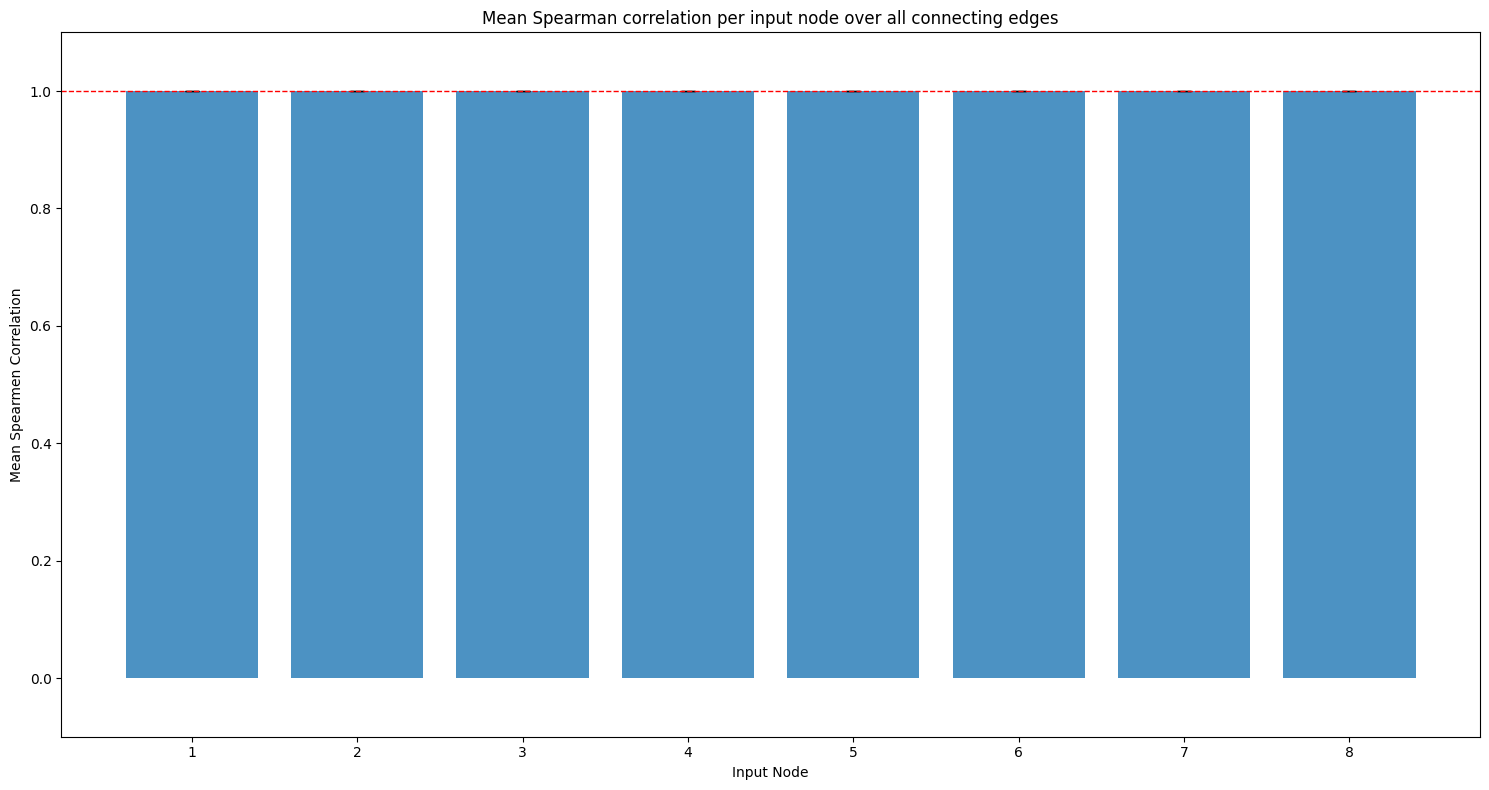

In [279]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_with_std(data):
    # Calculate mean and standard deviation for each row
    means = [np.mean(row) for row in data]
    std_devs = [np.std(row) for row in data]

    # Adjust error bars to not exceed correlation limits
    lower_errors = [min(m, s) if m > 0 else min(1 + m, s) for m, s in zip(means, std_devs)]
    upper_errors = [min(1 - m, s) if m > 0 else min(1 - m, s) for m, s in zip(means, std_devs)]

    # Create bar plot
    fig, ax = plt.subplots(figsize=(15, 8))

    x = np.arange(len(data))

    ax.bar(x, means, align='center', alpha=0.8)
    ax.errorbar(x, means, yerr=[lower_errors, upper_errors], fmt='none', capsize=5, color='black')

    ax.set_xlabel('Input Node')
    ax.set_ylabel('Mean Spearmen Correlation')
    ax.set_title('Mean Spearman correlation per input node over all connecting edges')
    ax.set_xticks(x)
    ax.set_xticklabels(range(1, len(data) + 1))

    # Add horizontal lines at y=1 and y=-1
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=-1, color='red', linestyle='--', linewidth=1)
    ax.set_ylim(-.1, 1.1)

    plt.tight_layout()
    plt.show()

# Usage:
# plot_mean_with_std(grad_corr)

# Usage:
# plot_mean_with_std(grad_corr)
plot_mean_with_std(grad_corrs[1])